# Zeitreihenanalyse
Prognostizierung der Inflation bzw. des Verbraucherpreisindexes

In [1]:
import statsmodels.api as sm
from statsmodels.tsa.stattools import ccf
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.ar_model import AutoReg
from sklearn.metrics import mean_squared_error 
from matplotlib.ticker import MaxNLocator
from scipy.interpolate import interp1d
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from itertools import chain 
from sklearn.pipeline import make_pipeline
def mean_absolute_percentage_error(y_true, y_pred): 
     return np.mean(np.abs((y_true - y_pred) / y_true)) *100
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Daten einlesen
rowData = pd.read_csv("VPI.csv")

In [3]:
# Daten anschauen
rowData.columns

Index(['Datum', 'VPI'], dtype='object')

VPI = Verbraucherpreis-Index 
Der Verbraucherpreisindex ist ein Maß für die durchschnittliche Veränderung der Preise, die von städtischen Verbrauchern für einen Marktkorb von Konsumgütern und Dienstleistungen gezahlt werden. 

In [4]:
rowData.head()

,Datum,VPI
0,7/24/2008,100.0
1,7/25/2008,100.0
2,7/26/2008,100.0
3,7/27/2008,100.0
4,7/28/2008,100.0


In [5]:
rowData.tail()

,Datum,VPI
4117,11/1/2019,NaN
4118,11/2/2019,NaN
4119,11/3/2019,NaN
4120,11/4/2019,NaN
4121,11/5/2019,NaN


In [6]:
# Daten bereinigen
rowData = rowData.dropna()

In [7]:
rowData.isna().sum()

Datum    0
VPI      0
dtype: int64

In [8]:
# Datenformat Konvertieren
rowData['Datum'] = pd.to_datetime(rowData['Datum'])
rowData['Datum'] = rowData['Datum'].dt.strftime('%Y-%m')  

In [9]:
# Bereinigte und konvertierte Daten seperat speichern
cleanedData = rowData.drop_duplicates('Datum', keep='last').copy().reset_index().drop(['index'],axis=1)

In [10]:
cleanedData.head()

,Datum,VPI
0,2008-07,100.00000
1,2008-08,100.52510
2,2008-09,100.12380
3,2008-10,99.98538
4,2008-11,98.97539


In [11]:
cleanedData.tail()

,Datum,VPI
131,2019-06,117.0359
132,2019-07,117.0592
133,2019-08,117.2548
134,2019-09,117.2488
135,2019-10,117.3407


In [12]:
cleanedData_train = (cleanedData[cleanedData.Datum<'2013-09'].copy())
cleanedData_test = (cleanedData[cleanedData.Datum>='2013-09'].copy())

In [13]:
# Daten in Trainings- und Testdaten splitten
X_train = np.array(cleanedData_train.index)
X_test = np.array(cleanedData_test.index)

In [14]:
y_train = np.array(cleanedData_train.VPI)
y_test = np.array(cleanedData_test.VPI)

In [15]:
len(y_test)

74

In [16]:
model = LinearRegression()
model.fit(X_train.reshape(-1,1), y_train)
# Ermitteln des Trends (Steigung) und den Achsenabschnitt
model.coef_[0], model.intercept_

(0.1610434836695122, 96.72932632872502)

In [17]:
y_pred_linear = model.predict(X_train.reshape(-1,1))
residuals_train = y_train-y_pred_linear

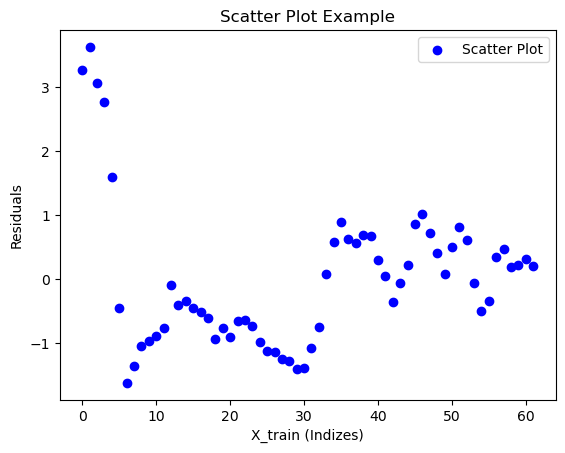

In [18]:
# Punktdiagramm
plt.scatter(X_train, residuals_train, label='Scatter Plot', color='blue', marker='o')

# Anpassen des Plots
plt.title('Scatter Plot Example')
plt.xlabel('X_train (Indizes)')
plt.ylabel('Residuals')
plt.legend()

# Anzeigen des Plots
plt.show()

In [19]:
# Maximalwert der Residuen
max(residuals_train)

3.634730187605456

## AR Model: Bestimmung der Verzögerung (Lag)

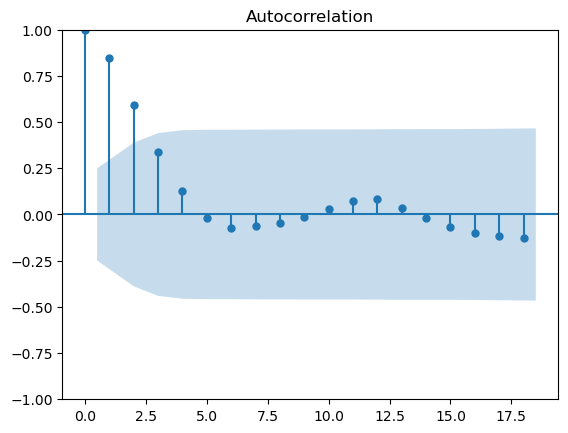

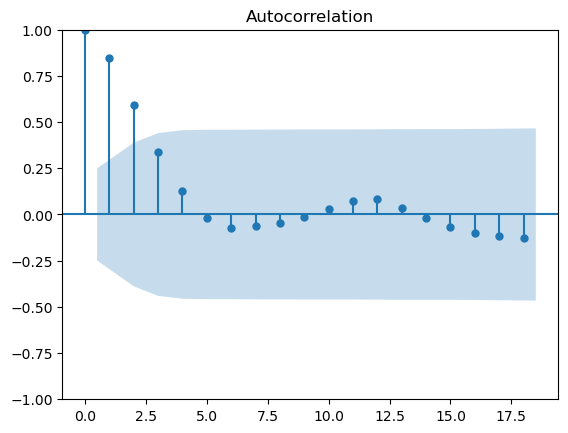

In [20]:
plot_acf(residuals_train)

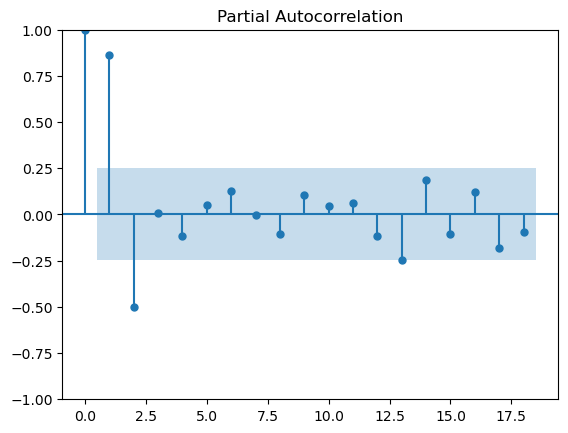

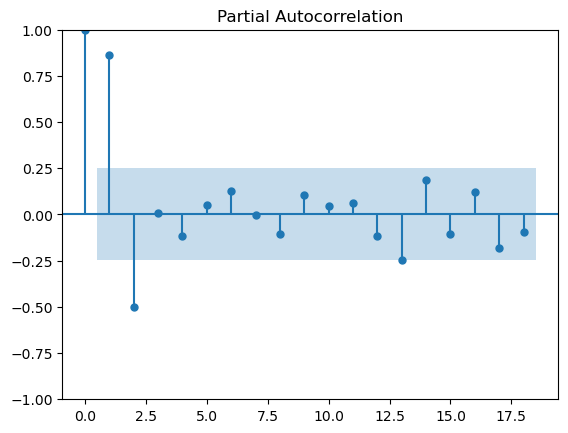

In [21]:
plot_pacf(residuals_train)

## AR Model: Bestimmung der Parameter 

In [22]:
model = AutoReg(endog=residuals_train, lags=2)

In [23]:
# Das Modell anpassen
result = model.fit()

# Anzeige der geschätzten Koeffizienten
print("AR Model Coefficients:")
print(result.params)

AR Model Coefficients:
[-0.04310485  1.32366553 -0.5307974 ]


## Mean Squared Error 

In [24]:
model = LinearRegression()
model.fit(X_train.reshape(-1,1), y_train)

LinearRegression()

In [25]:
y_pred_test = model.predict(X_test.reshape(-1,1))
residuals_test = y_test-y_pred_test

In [26]:
autoRegModel= AutoReg(endog=residuals_train, lags=2).fit()

In [27]:
autorRegPred = autoRegModel.predict(start=len(X_train), end = len(X_train)+len(X_test)-1)

In [28]:
test_predictions = []
past = []
coef = autoRegModel.params
lag = 2
for t in range(len(residuals_test)):
    pred = coef[0]
    for d in range(lag):
        pred += coef[d+1] 
    obs = residuals_test[t]
    test_predictions.append(pred)
    past.append(obs)
rmse = np.sqrt(mean_squared_error(residuals_test,test_predictions))
rmse

2.4689637955878436

# Umrechnung in Inflationsraten
## Inflationsrate vom VPI 

In [29]:
def calc_inflation_rate_1(VPI):
    inflation_rate = []
    for i in range(1,len(VPI)):
        inflation_rate.append((VPI[i]-VPI[i-1])/VPI[i-1] *100) # in Prozent     
    return inflation_rate

def calc_inflation_rate_2(VPI):
    inflation_rate = []
    for i in range(1,len(VPI)):
        inflation_rate.append((np.log(VPI[i])-np.log(VPI[i-1])) * 100)
    return inflation_rate

In [30]:
inflation_rate_VPI_1 = calc_inflation_rate_1(cleanedData.VPI)
inflation_rate_VPI_2 = calc_inflation_rate_2(cleanedData.VPI)

In [31]:
index_feb_2013 = cleanedData[cleanedData["Datum"]=="2013-02"].index[0]

In [32]:
cleanedData.iloc[index_feb_2013],cleanedData.iloc[index_feb_2013-1]

(Datum     2013-02
 VPI      105.2396
 Name: 55, dtype: object,
 Datum     2013-01
 VPI      104.9293
 Name: 54, dtype: object)

In [33]:
# Inflationsrate vom Februar 2023
inflation_rate_VPI_1[index_feb_2013-1], inflation_rate_VPI_2[index_feb_2013-1]

(0.2957229296297584, 0.2952865295193341)

## Inflationsrate von BER 

BER = break-even rate = Rentabilitätsschwelle
BER ist der Renditeunterschied zwischen einer festverzinslichen und einer inflationsbereinigten 10-jährigen Schatzanweisung. 

In [34]:
ber = pd.read_csv("T10YIE.csv")
ber.head()

,Datum,T10YIE
0,2003-01-02,1.64
1,2003-01-03,1.62
2,2003-01-06,1.63
3,2003-01-07,1.62
4,2003-01-08,1.71


In [35]:
ber.describe

<bound method NDFrame.describe of            Datum  T10YIE
0     2003-01-02    1.64
1     2003-01-03    1.62
2     2003-01-06    1.63
3     2003-01-07    1.62
4     2003-01-08    1.71
...          ...     ...
4388  2019-10-29    1.61
4389  2019-10-30    1.57
4390  2019-10-31    1.54
4391  2019-11-01    1.59
4392  2019-11-04    1.64

[4393 rows x 2 columns]>

In [36]:
ber["Datum"] = pd.to_datetime(ber["Datum"])

In [37]:
ber["YearMonth"] = ber["Datum"].dt.strftime('%Y-%m')

In [38]:
ber.head()

,Datum,T10YIE,YearMonth
0,2003-01-02,1.64,2003-01
1,2003-01-03,1.62,2003-01
2,2003-01-06,1.63,2003-01
3,2003-01-07,1.62,2003-01
4,2003-01-08,1.71,2003-01


In [39]:
ber = ber.dropna()

In [40]:
ber_inflation = pd.DataFrame(columns =['YearMonth','T10M'])

In [41]:
ber_inflation

,YearMonth,T10M


In [42]:
ber_inflation['YearMonth'], ber_inflation['T10M'] = ber["YearMonth"].unique(), ber.groupby("YearMonth").T10YIE.mean().values

In [43]:
ber_inflation.head()

,YearMonth,T10M
0,2003-01,1.754286
1,2003-02,1.912632
2,2003-03,1.862857
3,2003-04,1.774762
4,2003-05,1.660952


In [44]:
ber_inflation["inflaton"] = ((ber_inflation["T10M"].values/100+1)**(1/12)-1)*100

In [45]:
ber_inflation[ber_inflation["YearMonth"]=="2013-02"]

,YearMonth,T10M,inflaton
121,2013-02,2.554737,0.210442


## Perognosegenauigkeit mittels BER steigern

In [46]:
inflation_rate_VPI_1==inflation_rate_VPI_2

False

In [47]:
irData = cleanedData

In [48]:
irData.head()

,Datum,VPI
0,2008-07,100.00000
1,2008-08,100.52510
2,2008-09,100.12380
3,2008-10,99.98538
4,2008-11,98.97539


In [49]:
irData = irData.drop(0)

In [50]:
irData.head()

,Datum,VPI
1,2008-08,100.52510
2,2008-09,100.12380
3,2008-10,99.98538
4,2008-11,98.97539
5,2008-12,97.07973


In [51]:
irData["IR"] = inflation_rate_VPI_1

In [52]:
irData.head()

,Datum,VPI,IR
1,2008-08,100.52510,0.525100
2,2008-09,100.12380,-0.399204
3,2008-10,99.98538,-0.138249
4,2008-11,98.97539,-1.010138
5,2008-12,97.07973,-1.915284


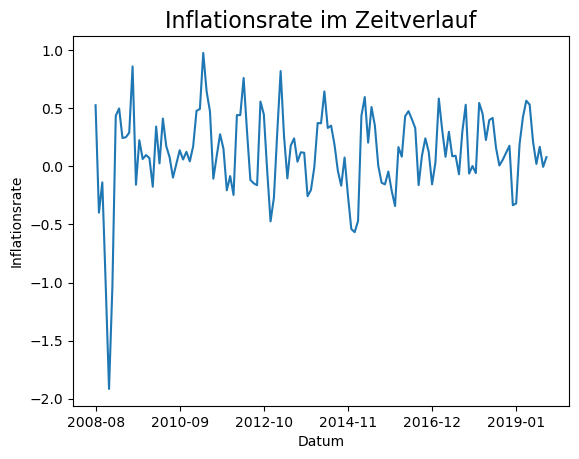

In [53]:
# Erstellen eines Plots
fig, ax = plt.subplots()

# Plotten der Daten
ax.plot(irData["Datum"].values, irData["IR"].values)

# Setzen Sie die maximale Anzahl der Ticks für die x-Achse
ax.xaxis.set_major_locator(MaxNLocator(nbins=6))  # Setzen Sie die gewünschte maximale Anzahl von Ticks.

# Beschriftungen und eine Legende hinzufügen
ax.set_xlabel('Datum')
ax.set_ylabel('Inflationsrate')
ax.set_title('Inflationsrate im Zeitverlauf', fontsize=16)

# Speichern der Darstellung in einer PNG-Datei
plt.savefig('Plots/Inflationsrate im Zeitverlauf.png')

# Zeigt das Diagramm
plt.show();

In [54]:
irData_train = (irData[irData.Datum<'2013-09'].copy())
irData_test = (irData[irData.Datum >='2013-09'].copy())

In [55]:
X_train = np.array(irData_train.index)
X_test = np.array(irData_test.index)

In [56]:
y_train = np.array(irData_train.IR)
y_test = np.array(irData_test.IR)

In [57]:
y_train

array([ 0.5251    , -0.39920378, -0.13824885, -1.01013768, -1.91528419,
       -1.03424268,  0.43524017,  0.49727521,  0.24317936,  0.24963607,
        0.28888015,  0.85898723, -0.15856234,  0.2242907 ,  0.06255217,
        0.09631268,  0.07076311, -0.17611003,  0.34174612,  0.02492237,
        0.41063209,  0.17368982,  0.07750548, -0.09763423,  0.02112205,
        0.1380673 ,  0.05817372,  0.12452397,  0.04205999,  0.17188942,
        0.47630742,  0.49312673,  0.97508597,  0.64391046,  0.47050308,
       -0.1071008 ,  0.08860315,  0.27574384,  0.15183609, -0.20628817,
       -0.08436739, -0.24664204,  0.44001136,  0.44030409,  0.75948929,
        0.30209722, -0.1173556 , -0.14662882, -0.16295885,  0.55653081,
        0.44621783, -0.03895808, -0.47382785, -0.26926433,  0.29572293,
        0.81898829,  0.26144776, -0.10396799,  0.17803992,  0.24000188,
        0.03945161])

In [58]:
len(y_test)

74

In [59]:
model = LinearRegression()
model.fit(X_train.reshape(-1,1), y_train)
# Get the trend (slope) and intercept
model.coef_[0], model.intercept_

(0.0054937024691356084, -0.062055837951468004)

In [60]:
y_pred_linear_train = model.predict(X_train.reshape(-1,1))
y_pred_linear_test = model.predict(X_test.reshape(-1,1))
residuals_train = y_train-y_pred_linear_train

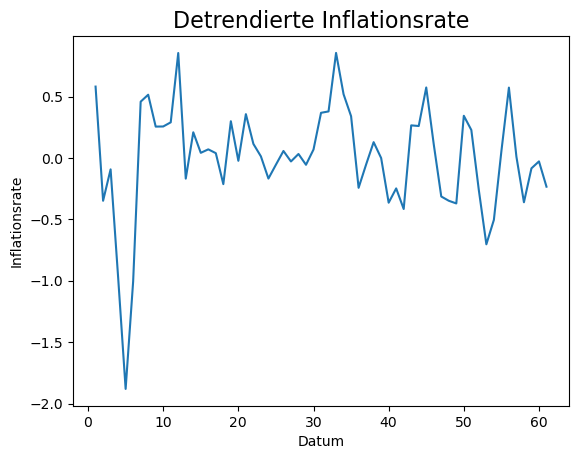

In [61]:
# Erstellen eines Plots
fig, ax = plt.subplots()

# Plotten Sie die Daten
ax.plot( X_train, residuals_train)

# Setzen Sie die maximale Anzahl der Ticks für die x-Achse
#ax.xaxis.set_major_locator(MaxNLocator(nbins=6))  # Setzen Sie die gewünschte maximale Anzahl von Ticks.

# Beschriftungen und eine Legende hinzufügen
ax.set_xlabel('Datum')
ax.set_ylabel('Inflationsrate')
ax.set_title('Detrendierte Inflationsrate', fontsize=16)

# Speichern der Darstellung in einer PNG-Datei
plt.savefig('Plots/Detrendierte Daten.png')

# Anzeige der Darstellung
plt.show()

## 3.

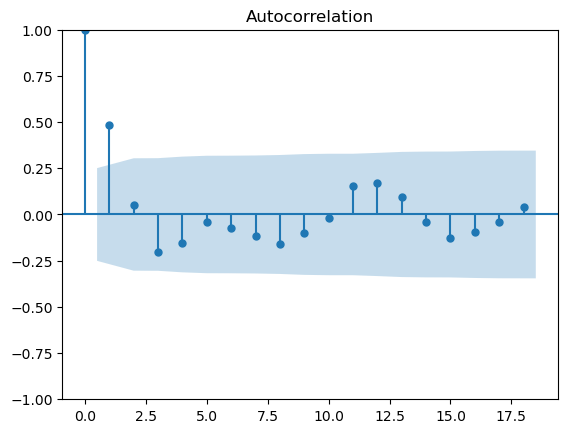

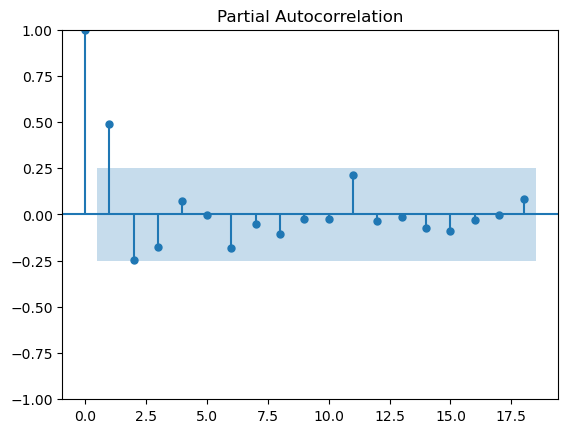

In [62]:
#lineare
plot_acf(residuals_train)
# Speichern der Darstellung in einer PNG-Datei
plt.savefig('Plots/Autokorrelation.png')
plt.show()

plot_pacf(residuals_train)
# Speichern der Darstellung in einer PNG-Datei
plt.savefig('Plots/Teilautokorrelation.png')
plt.show()

In [63]:
irData.head()

,Datum,VPI,IR
1,2008-08,100.52510,0.525100
2,2008-09,100.12380,-0.399204
3,2008-10,99.98538,-0.138249
4,2008-11,98.97539,-1.010138
5,2008-12,97.07973,-1.915284


In [64]:
# Die Spalte durch "-" teilen und den rechten Teil nehmen
irData['month'] = irData['Datum'].str.split('-').str[1]
irData.head()

,Datum,VPI,IR,month
1,2008-08,100.52510,0.525100,08
2,2008-09,100.12380,-0.399204,09
3,2008-10,99.98538,-0.138249,10
4,2008-11,98.97539,-1.010138,11
5,2008-12,97.07973,-1.915284,12


In [65]:
month_mean = irData.groupby("month").IR.mean()

In [66]:
month_mean

month
01   -0.256105
02    0.306726
03    0.395604
04    0.471929
05    0.317824
06    0.261393
07    0.171156
08    0.021948
09    0.087388
10    0.131742
11   -0.122725
12   -0.345817
Name: IR, dtype: float64

In [67]:
irData_train = (irData[irData.Datum<'2013-09'].copy())
irData_test = (irData[irData.Datum >='2013-09'].copy())

In [68]:
periodisch_train = list(chain.from_iterable(month_mean[irData_train.month].values[..., np.newaxis])) 
periodisch_test = list(chain.from_iterable(month_mean[irData_test.month].values[..., np.newaxis])) 
len(periodisch_train)

61

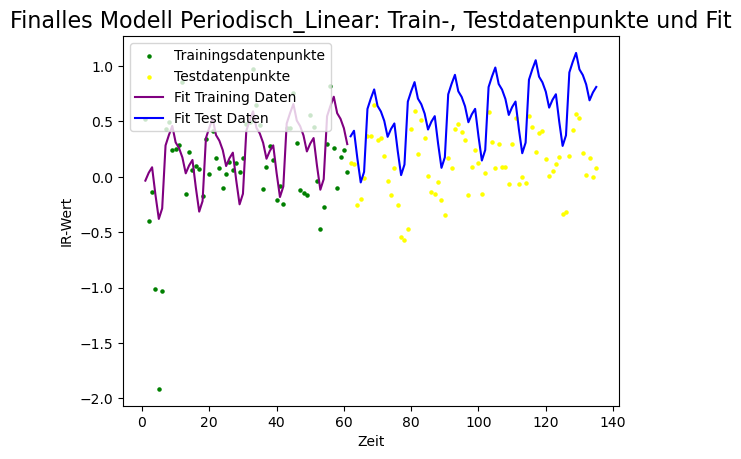

In [69]:
plt.scatter(X_train,y_train, color='green', s=5, label='Trainingsdatenpunkte')
plt.scatter(X_test,y_test, color='yellow', s=5, label='Testdatenpunkte')
plt.plot(X_train,y_pred_linear_train + periodisch_train, linestyle='-', color='purple', label='Fit Training Daten')
plt.plot(X_test,y_pred_linear_test+ periodisch_test, linestyle='-', color='blue', label='Fit Test Daten')
plt.legend(loc='upper left')
plt.title('Finalles Modell Periodisch_Linear: Train-, Testdatenpunkte und Fit', fontsize=16)
plt.xlabel('Zeit')
plt.ylabel('IR-Wert')
plt.savefig('Plots/IR_periodisch_Linear_Train-, Testdatenpunkte und Fit.png')
plt.show()

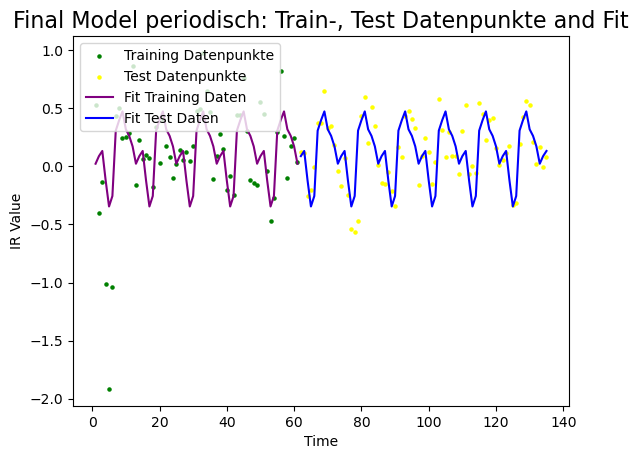

In [70]:
plt.scatter(X_train,y_train,  color='green', s=5, label='Training Datenpunkte')
plt.scatter(X_test,y_test,  color='yellow', s=5, label='Test Datenpunkte')
plt.plot(X_train, periodisch_train, linestyle='-', color='purple', label='Fit Training Daten')
plt.plot(X_test, periodisch_test, linestyle='-', color='blue', label='Fit Test Daten')
plt.legend(loc='upper left')
plt.title('Final Model periodisch: Train-, Test Datenpunkte and Fit', fontsize=16)
plt.xlabel('Time')
plt.ylabel('IR Value')
plt.savefig('Plots/IR_periodisch_Train-, Test Datenpunkte and Fit.png')
plt.show()

In [71]:
final_test_periodisch = periodisch_test
rmse_final_periodisch =  mean_squared_error(y_test, final_test_periodisch, squared=False)
mape_final_periodisch = mean_absolute_percentage_error(y_test, final_test_periodisch)*100

final_test_linear_periodisch = y_pred_linear_test + periodisch_test
rmse_final_linear_periodisch =  mean_squared_error(y_test, final_test_linear_periodisch, squared=False)
mape_final_linear_periodisch = mean_absolute_percentage_error(y_test, final_test_linear_periodisch)*100

print(f"RMSE periodisch: [{rmse_final_periodisch}]")
print(f"MAPE periodisch: [{mape_final_periodisch}]")
print(f"RMSE linear periodisch: [{rmse_final_linear_periodisch}]")
print(f"MAPE linear periodisch: [{mape_final_linear_periodisch}]")

RMSE periodisch: [0.1908829838295605]
MAPE periodisch: [35825.174860299194]
RMSE linear periodisch: [0.5152007224159337]
MAPE linear periodisch: [88023.72855540003]


In [72]:
rmse_train=[]

for n in range(1,25):
    model = AutoReg(residuals_train , lags= n,trend='n')
    model_fit = model.fit()
    predictions=model_fit.predict()
    rmse=(mean_squared_error(residuals_train[n:], predictions[n:]))**0.5
    rmse_train.append(rmse)

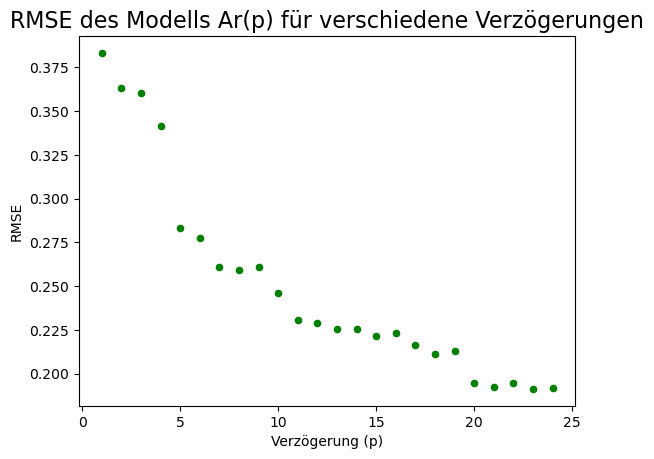

In [73]:
plt.scatter(range(1,25),rmse_train,  color='green', s=20 )
plt.title('RMSE des Modells Ar(p) für verschiedene Verzögerungen', fontsize=16)
plt.xlabel('Verzögerung (p)')
plt.ylabel('RMSE')
plt.savefig('Plots/RMSE des Ar(p)-Modells für verschiedene Verzögerungen.png')
plt.show()

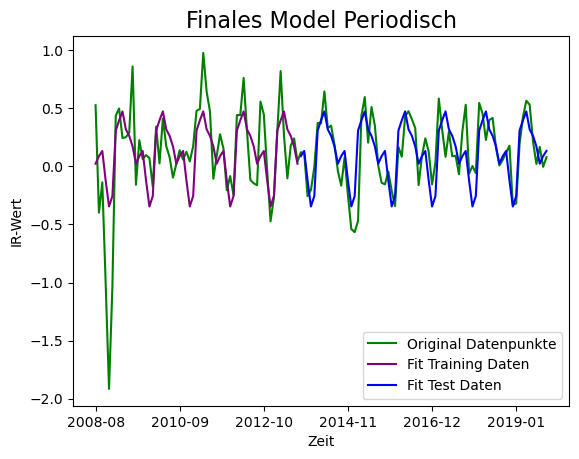

In [74]:
plt.plot(irData["Datum"].values ,np.concatenate((y_train, y_test)), color='green', label='Original Datenpunkte')
plt.plot(irData_train["Datum"].values, periodisch_train, color='purple', label='Fit Training Daten')
plt.plot(irData_test["Datum"].values, periodisch_test, color='blue', label='Fit Test Daten')
plt.legend(loc='upper left')
plt.title('Finales Model Periodisch', fontsize=16)
plt.xlabel('Zeit')
plt.ylabel('IR-Wert')
plt.legend(loc='lower right')
plt.gca().xaxis.set_major_locator(MaxNLocator(nbins=7))  
plt.savefig('Plots/Final Model Periodisch.png')
plt.show()

# Externe Regressoren und Modellverbesserungen

In [75]:
# Ber-Data laden und vorbereiten
ber = pd.read_csv("T10YIE.csv")
ber["Datum"] = pd.to_datetime(ber["Datum"])
ber["Datum"] = ber["Datum"].dt.strftime('%Y-%m')
ber = ber.dropna()
ber_inflation = pd.DataFrame(columns =['Datum','T10M'])
ber_inflation['Datum'], ber_inflation['T10M'] = ber["Datum"].unique(), ber.groupby("Datum").T10YIE.mean().values
ber_inflation["BER_inflaton"] = ((ber_inflation["T10M"].values/100+1)**(1/12)-1)*100
print("length: ", len(ber_inflation))
ber_inflation.head()

length:  203


,Datum,T10M,BER_inflaton
0,2003-01,1.754286,0.145028
1,2003-02,1.912632,0.158006
2,2003-03,1.862857,0.153928
3,2003-04,1.774762,0.146707
4,2003-05,1.660952,0.137370


In [76]:
#VPI-Daten laden und vorbereiten
rowData = pd.read_csv("VPI.csv")
rowData = rowData.dropna()
# Convert to datetime type
rowData['Datum'] = pd.to_datetime(rowData['Datum'])
rowData['Datum'] = rowData['Datum'].dt.strftime('%Y-%m') 
VPI_Data = rowData.drop_duplicates('Datum', keep='last').copy().reset_index().drop(['index'],axis=1)
# Infiltrationsrate berechnen
inflation_rate_VPI_1 = calc_inflation_rate_1(cleanedData.VPI)
# erste Zeile "streichen", da die Inflationsrate ein Element weniger hat
VPI_Data.drop(0, inplace = True)
VPI_Data["VPI_inflation"] = inflation_rate_VPI_1
print("length: ", len(VPI_Data))
VPI_Data.head()

length:  135


,Datum,VPI,VPI_inflation
1,2008-08,100.52510,0.525100
2,2008-09,100.12380,-0.399204
3,2008-10,99.98538,-0.138249
4,2008-11,98.97539,-1.010138
5,2008-12,97.07973,-1.915284


In [77]:
VPI_BER = pd.merge(ber_inflation, VPI_Data, on='Datum')
print(f"length: ", len(VPI_BER))
VPI_BER.head()

length:  135


,Datum,T10M,BER_inflaton,VPI,VPI_inflation
0,2008-08,2.209524,0.182288,100.52510,0.525100
1,2008-09,1.836190,0.151743,100.12380,-0.399204
2,2008-10,1.061818,0.088057,99.98538,-0.138249
3,2008-11,0.638333,0.053039,98.97539,-1.010138
4,2008-12,0.246364,0.020507,97.07973,-1.915284


In [78]:
# Berechnen der Kreuzkorrelation
VPI_BER["ccf"] = ccf(VPI_BER['VPI_inflation'], VPI_BER['BER_inflaton'])

In [79]:
# Suche nach der Verzögerung, die der maximalen Korrelation entspricht
max_corr_lag = np.argmax(VPI_BER["ccf"].values)
max_corr_lag

0

In [80]:
VPI_BER.head()

,Datum,T10M,BER_inflaton,VPI,VPI_inflation,ccf
0,2008-08,2.209524,0.182288,100.52510,0.525100,0.468952
1,2008-09,1.836190,0.151743,100.12380,-0.399204,0.377014
2,2008-10,1.061818,0.088057,99.98538,-0.138249,0.165666
3,2008-11,0.638333,0.053039,98.97539,-1.010138,-0.037735
4,2008-12,0.246364,0.020507,97.07973,-1.915284,-0.143816


In [81]:
len(VPI_BER.ccf)

135

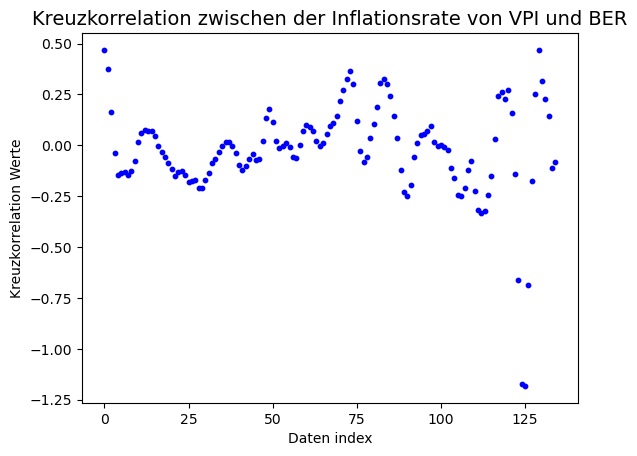

In [82]:
plt.scatter(VPI_BER.index , VPI_BER["ccf"] .values, color='blue', s=10)
plt.title('Kreuzkorrelation zwischen der Inflationsrate von VPI und BER' , fontsize=14)
plt.xlabel('Daten index')
plt.ylabel('Kreuzkorrelation Werte')
plt.gca().xaxis.set_major_locator(MaxNLocator(nbins=7))  
plt.savefig('Plots/Kreuzkorrelation zwischen VPI und BER.png')
plt.show()

In [83]:
VPI_BER_train = VPI_BER[VPI_BER["Datum"]<'2013-09'].copy()
VPI_BER_test = VPI_BER[VPI_BER["Datum"]>='2013-09'].copy()

In [84]:
model = sm.tsa.statespace.SARIMAX(endog=VPI_BER_train.VPI_inflation,  order=(2, 0, 0), coerce_errors =True)

In [85]:
sarimax_results_train = model.fit(disp=False)

In [86]:
coef = sarimax_results_train.params
coef

ar.L1     0.676564
ar.L2    -0.235754
sigma2    0.144495
dtype: float64

In [87]:
# Display model summary
print(sarimax_results_train.summary())

                               SARIMAX Results                                
Dep. Variable:          VPI_inflation   No. Observations:                   61
Model:               SARIMAX(2, 0, 0)   Log Likelihood                 -27.789
Date:                Sun, 30 Jun 2024   AIC                             61.578
Time:                        15:01:28   BIC                             67.910
Sample:                             0   HQIC                            64.059
                                 - 61                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6766      0.120      5.641      0.000       0.441       0.912
ar.L2         -0.2358      0.111     -2.130      0.033      -0.453      -0.019
sigma2         0.1445      0.024      6.079      0.0

In [88]:
sarimax_results_test = model.fit(VPI_BER_test.VPI_inflation)

In [89]:
prediction_train = sarimax_results_train.predict(start=0, end=len(VPI_BER_train.VPI_inflation)-1)

In [90]:
k= 2
coef = sarimax_results_train.params
past = VPI_BER_train.VPI_inflation[len(VPI_BER_train.VPI_inflation)-k:].values 
past = [past[i] for i in range(k)]
prediction_test = list()

In [91]:
#Vorhersage des ersten Zeitschritts
pred = coef['ar.L2']*past[0] + coef['ar.L1']*past[1] + VPI_BER_test.BER_inflaton.iloc[0] 
prediction_test.append(pred)
obs = VPI_BER_test.VPI_inflation.values[0]
past.append(obs)

In [92]:
prediction_test = []
for t in range(1,len(VPI_BER_test.VPI_inflation)):
    length = len(past)
    lag = [past[i] for i in range(length-2,length)]
    pred =  coef['ar.L2']*lag[0] + coef['ar.L1']*lag[1] + VPI_BER_test.BER_inflaton.iloc[t]  
    prediction_test.append(pred)
    obs = VPI_BER_test.VPI_inflation.values[t]
    past.append(obs)

In [93]:
VPI_BER_test_redu = VPI_BER_test.drop(61)

In [94]:
print("Der rmse des endgültigen fits ist: " + str(mean_squared_error(VPI_BER_test_redu.VPI_inflation.values[:-2], prediction_test[:-2])**0.5))
print("Der map des endgültigen fits ist: " + str(mean_absolute_percentage_error(VPI_BER_test_redu.VPI_inflation.values[:-2],prediction_test[:-2])))

Der rmse des endgültigen fits ist: 0.2458896406086514
Der map des endgültigen fits ist: 235.90397651248622


In [95]:
len(VPI_BER_test_redu.index), len(prediction_test)

(73, 73)

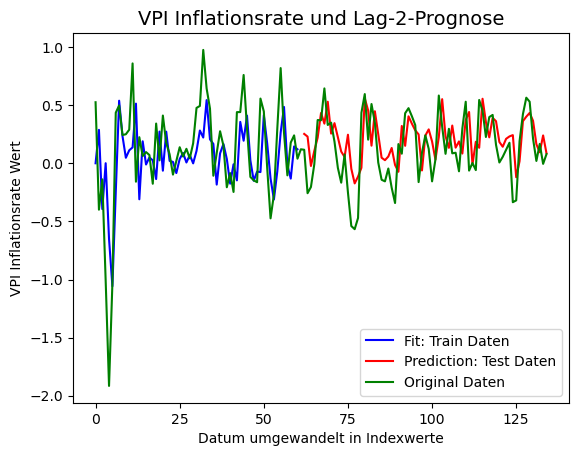

In [96]:
plt.plot(VPI_BER_train.index , prediction_train, color='blue', label="Fit: Train Daten")
plt.plot(VPI_BER_test_redu.index , prediction_test, color='red', label="Prediction: Test Daten")
plt.plot(VPI_BER.index , VPI_BER.VPI_inflation, color='green', label="Original Daten")
plt.title('VPI Inflationsrate und Lag-2-Prognose' , fontsize=14)
plt.legend(loc='lower right')
plt.xlabel('Datum umgewandelt in Indexwerte')
plt.ylabel('VPI Inflationsrate Wert')
plt.gca().xaxis.set_major_locator(MaxNLocator(nbins=7)) 
plt.savefig('Plots/VPI Inflationsrate und Lag-2-Prognose.png')
plt.show()

#### lag 1 model

In [97]:
VPI_BER_train = VPI_BER[VPI_BER["Datum"]<'2013-09'].copy()
VPI_BER_test = VPI_BER[VPI_BER["Datum"]>='2013-09'].copy()

In [98]:
model = sm.tsa.statespace.SARIMAX(endog=VPI_BER_train.VPI_inflation,  order=(1, 0, 0), coerce_errors =True)

In [99]:
sarimax_results_train = model.fit(disp=False)

In [100]:
coef = sarimax_results_train.params
coef

ar.L1     0.541228
sigma2    0.152916
dtype: float64

In [101]:
# Zusammenfassung des Modells anzeigen
print(sarimax_results_train.summary())

                               SARIMAX Results                                
Dep. Variable:          VPI_inflation   No. Observations:                   61
Model:               SARIMAX(1, 0, 0)   Log Likelihood                 -29.454
Date:                Sun, 30 Jun 2024   AIC                             62.909
Time:                        15:01:29   BIC                             67.131
Sample:                             0   HQIC                            64.563
                                 - 61                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5412      0.083      6.540      0.000       0.379       0.703
sigma2         0.1529      0.021      7.207      0.000       0.111       0.194
Ljung-Box (L1) (Q):                   0.67   Jarque-

In [102]:
sarimax_results_test = model.fit(VPI_BER_test.VPI_inflation)

In [103]:
prediction_train = sarimax_results_train.predict(start=0, end=len(VPI_BER_train.VPI_inflation)-1)

In [104]:
k = 1
coef = sarimax_results_train.params
past = VPI_BER_train.VPI_inflation[len(VPI_BER_train.VPI_inflation)-k:].values #exact the last k items in training data
past = [past[i] for i in range(k)]
prediction_test = list()

In [105]:
#Vorhersage des ersten Zeitschritts
pred = coef['ar.L1']*past[0] + VPI_BER_test.BER_inflaton.iloc[0] 
prediction_test.append(pred)
obs = VPI_BER_test.VPI_inflation.values[0]
past.append(obs)

In [106]:
prediction_test = []
for t in range(1,len(VPI_BER_test.VPI_inflation)):
    length = len(past)
    lag = [past[i] for i in range(length-1,length)]
    pred =  coef['ar.L1']*lag[0] + VPI_BER_test.BER_inflaton.iloc[t]  
    prediction_test.append(pred)
    obs = VPI_BER_test.VPI_inflation.values[t]
    past.append(obs)

In [107]:
VPI_BER_test_redu = VPI_BER_test.drop(61)

In [108]:
print("Der rmse des endgültigen fits ist: " + str(mean_squared_error(VPI_BER_test_redu.VPI_inflation.values[:-1], prediction_test[:-1])**0.5))
print("Der map des endgültigen fits ist: " + str(mean_absolute_percentage_error(VPI_BER_test_redu.VPI_inflation.values[:-1],prediction_test[:-1])))

Der rmse des endgültigen fits ist: 0.2572520250335094
Der map des endgültigen fits ist: 394.72246462034207


In [109]:
len(VPI_BER_test_redu.index), len(prediction_test)

(73, 73)

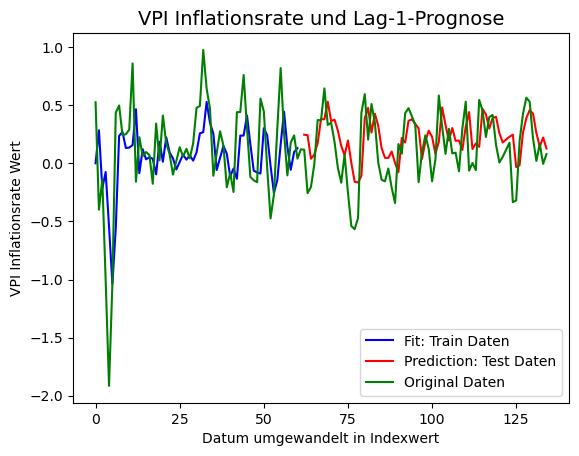

In [110]:
plt.plot(VPI_BER_train.index , prediction_train, color='blue', label="Fit: Train Daten")
plt.plot(VPI_BER_test_redu.index , prediction_test, color='red', label="Prediction: Test Daten")
plt.plot(VPI_BER.index , VPI_BER.VPI_inflation, color='green', label="Original Daten")
plt.title('VPI Inflationsrate und Lag-1-Prognose' , fontsize=14)
plt.legend(loc='lower right')
plt.xlabel('Datum umgewandelt in Indexwert')
plt.ylabel('VPI Inflationsrate Wert')
plt.gca().xaxis.set_major_locator(MaxNLocator(nbins=7))  
plt.savefig('Plots/VPI Inflationsrate und Lag-1-Prognose.png')
plt.show()

In [111]:
VPI_BER_train = VPI_BER[VPI_BER["Datum"]<'2013-09'].copy()
VPI_BER_test = VPI_BER[VPI_BER["Datum"]>='2013-09'].copy()

                               SARIMAX Results                                
Dep. Variable:          VPI_inflation   No. Observations:                   61
Model:               SARIMAX(2, 0, 1)   Log Likelihood                 -27.651
Date:                Sun, 30 Jun 2024   AIC                             63.303
Time:                        15:01:29   BIC                             71.746
Sample:                             0   HQIC                            66.612
                                 - 61                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8869      0.692      1.281      0.200      -0.470       2.243
ar.L2         -0.3520      0.407     -0.866      0.387      -1.149       0.445
ma.L1         -0.2215      0.661     -0.335      0.7

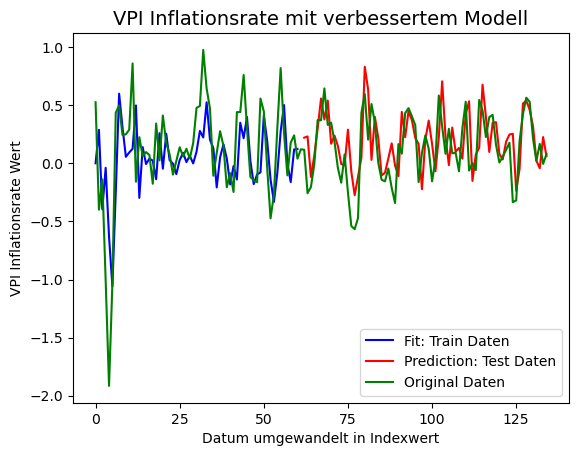

In [112]:
model = sm.tsa.statespace.SARIMAX(endog=VPI_BER_train.VPI_inflation,  order=(2, 0, 1), seasonal_order=(0,0,0,0), coerce_errors =True)

sarimax_results_train = model.fit(disp=False)

coef = sarimax_results_train.params

# Zusammenfassung des Modells anzeigen
print(sarimax_results_train.summary())

sarimax_results_test = model.fit(VPI_BER_test.VPI_inflation);

prediction_train = sarimax_results_train.predict(start=0, end=len(VPI_BER_train.VPI_inflation)-1)

coef = sarimax_results_train.params
k = len(coef)-1
past = VPI_BER_train.VPI_inflation[len(VPI_BER_train.VPI_inflation)-k:].values #exatrahiere die letzten k Elemente in den Trainingsdaten
past = [past[i] for i in range(k)]
prediction_test = list()

#Vorhersage des ersten Zeitschritts
constant = 0
for i in range(1, len(coef)):
    constant += coef[k-i]*past[i-1]
pred = constant + VPI_BER_test.BER_inflaton.iloc[0] 
prediction_test.append(pred)
obs = VPI_BER_test.VPI_inflation.values[0]
past.append(obs)

prediction_test = []
for t in range(1,len(VPI_BER_test.VPI_inflation)):
    length = len(past)
    lag = [past[i] for i in range(length-k,length)]
    constant = 0
    for i in range(1, len(coef)):
        constant += coef[k-i]*lag[i-1]
    pred =  constant + VPI_BER_test.BER_inflaton.iloc[t]  
    prediction_test.append(pred)
    obs = VPI_BER_test.VPI_inflation.values[t]
    past.append(obs)
VPI_BER_test_redu = VPI_BER_test.drop(61)

print("Der rmse des endgültigen fits ist: " + str(mean_squared_error(VPI_BER_test_redu.VPI_inflation.values[:-k], prediction_test[:-k])**0.5))
print("Der map des endgültigen fits ist: " + str(mean_absolute_percentage_error(VPI_BER_test_redu.VPI_inflation.values[:-k],prediction_test[:-k])))

plt.plot(VPI_BER_train.index , prediction_train, color='blue', label="Fit: Train Daten")
plt.plot(VPI_BER_test_redu.index , prediction_test, color='red', label="Prediction: Test Daten")
plt.plot(VPI_BER.index , VPI_BER.VPI_inflation, color='green', label="Original Daten")
plt.title('VPI Inflationsrate mit verbessertem Modell' , fontsize=14)
plt.legend(loc='lower right')
plt.xlabel('Datum umgewandelt in Indexwert')
plt.ylabel('VPI Inflationsrate Wert')
plt.gca().xaxis.set_major_locator(MaxNLocator(nbins=7))  
plt.savefig('Plots/VPI Inflationsrate mit verbessertem Modell.png')
plt.show()